# install dependencies in Collaboratory's machine

In [1]:
!pip install essentia
!apt-get install lilypond
!pip uninstall matplotlib
!pip install matplotlib==2.2.2

     |████████████████████████████████| 12.0MB 272kB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fonts-droid-fallback fonts-lmodern fonts-noto-mono ghostscript gsfonts
  libauthen-sasl-perl libcupsfilters1 libcupsimage2 libdata-dump-perl
  libencode-locale-perl libfile-listing-perl libfont-afm-perl libgs9
  libgs9-common libhtml-form-perl libhtml-format-perl libhtml-parser-perl
  libhtml-tagset-perl libhtml-tree-perl libhttp-cookies-perl
  libhttp-daemon-perl libhttp-date-perl libhttp-message-perl
  libhttp-negotiate-perl libijs-0.35 libio-html-perl libio-socket-ssl-perl
  libjbig2dec0 libkpathsea6 liblwp-mediatypes-perl liblwp-protocol-https-perl
  libmailtools-perl libnet-http-perl libnet-smtp-ssl-perl libnet-ssleay-perl
  libpotrace0 libptexenc1 libsynctex1 libtexlua52 libtexluajit2
  libtext-unidecode-perl libtimedate-perl libtry-tiny-perl liburi-perl
  libwww-perl libwww-r

# Link with gDrive

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
GLOBAL_PATH = '/content/drive/MyDrive/TFG'  

Mounted at /content/drive


# Imports

In [3]:
import pandas as pd
from sklearn import preprocessing
import seaborn as sns
from IPython.display import Image

import importlib
import joblib
import shutil
import sys
#importlib.reload(sys.modules['drums'])

sys.path.append(GLOBAL_PATH + '/scripts')
from utils import *
from feature_extraction import *
from drums import *
from plots import *
from visualization import *

sr = 44100

# Which exercise wants to assess

In [19]:
# useful paths
folder = GLOBAL_PATH + "/data/Testing/student/"
musical_feature_file = folder + 'features/Test_student'

# remove previous files from slices folder 
prev_files = get_files_in_dir(folder + 'slices')
for f in prev_files:
    os.remove(f)

# read txt that contains which features has to be extr
validation_features = []
with open(GLOBAL_PATH + '/data/features/features_used.txt') as f:
    used_features = f.read().splitlines()
f.close
for feature in used_features:
    validation_features.append("lowlevel." + feature)


audiofiles = get_files_in_dir(folder + 'submissions')
audiofiles = [x.split('/')[-1] for x in audiofiles if 'aif' in x]
audiofiles

#separate audio files in exercises 
exercises = []
for i in range(7):
    ex_list = []
    for j in range(4):
      ex_list.append(audiofiles[i + 7*j])
    exercises.append(ex_list)

for ex in exercises:
  print(ex)

# select an exercise form 0  to 6
test_exercises = exercises[0]

# define Ex, bpm and the selected exercise 
Ex = test_exercises[0].split('_')[-1].split('.')[0]
bpm = int(test_exercises[0].split('_')[-2])

lilypond = folder + "lilypond/Ex" + Ex + "_" + str(bpm) + ".ly"
annotation_file = folder +  "annotations/test_ex" + Ex + "_" + str(bpm) + ".txt"
submissions = folder + 'submissions/'

['badTempo_badReading_100_1.aif', 'badTempo_goodReading_100_1.aif', 'goodTempo_badReading_100_1.aif', 'goodTempo_goodReading_100_1.aif']
['badTempo_badReading_100_2.aif', 'badTempo_goodReading_100_2.aif', 'goodTempo_badReading_100_2.aif', 'goodTempo_goodReading_100_2.aif']
['badTempo_badReading_140_1.aif', 'badTempo_goodReading_140_1.aif', 'goodTempo_badReading_140_1.aif', 'goodTempo_goodReading_140_1.aif']
['badTempo_badReading_180_1.aif', 'badTempo_goodReading_180_1.aif', 'goodTempo_badReading_180_1.aif', 'goodTempo_goodReading_180_1.aif']
['badTempo_badReading_220_1.aif', 'badTempo_goodReading_220_1.aif', 'goodTempo_badReading_220_1.aif', 'goodTempo_goodReading_220_1.aif']
['badTempo_badReading_60_1.aif', 'badTempo_goodReading_60_1.aif', 'goodTempo_badReading_60_1.aif', 'goodTempo_goodReading_60_1.aif']
['badTempo_badReading_60_2.aif', 'badTempo_goodReading_60_2.aif', 'goodTempo_badReading_60_2.aif', 'goodTempo_goodReading_60_2.aif']


In [28]:
test_exercises

['badTempo_badReading_100_1.aif',
 'badTempo_goodReading_100_1.aif',
 'goodTempo_badReading_100_1.aif',
 'goodTempo_goodReading_100_1.aif']

['/content/drive/MyDrive/TFG/data/Testing/student/submissions/slices/10__blind.wav', '/content/drive/MyDrive/TFG/data/Testing/student/submissions/slices/11__blind.wav', '/content/drive/MyDrive/TFG/data/Testing/student/submissions/slices/12__blind.wav', '/content/drive/MyDrive/TFG/data/Testing/student/submissions/slices/13__blind.wav', '/content/drive/MyDrive/TFG/data/Testing/student/submissions/slices/14__blind.wav', '/content/drive/MyDrive/TFG/data/Testing/student/submissions/slices/15__blind.wav', '/content/drive/MyDrive/TFG/data/Testing/student/submissions/slices/16__blind.wav', '/content/drive/MyDrive/TFG/data/Testing/student/submissions/slices/17__blind.wav', '/content/drive/MyDrive/TFG/data/Testing/student/submissions/slices/18__blind.wav', '/content/drive/MyDrive/TFG/data/Testing/student/submissions/slices/19__blind.wav', '/content/drive/MyDrive/TFG/data/Testing/student/submissions/slices/210__blind.wav', '/content/drive/MyDrive/TFG/data/Testing/student/submissions/slices/211__b

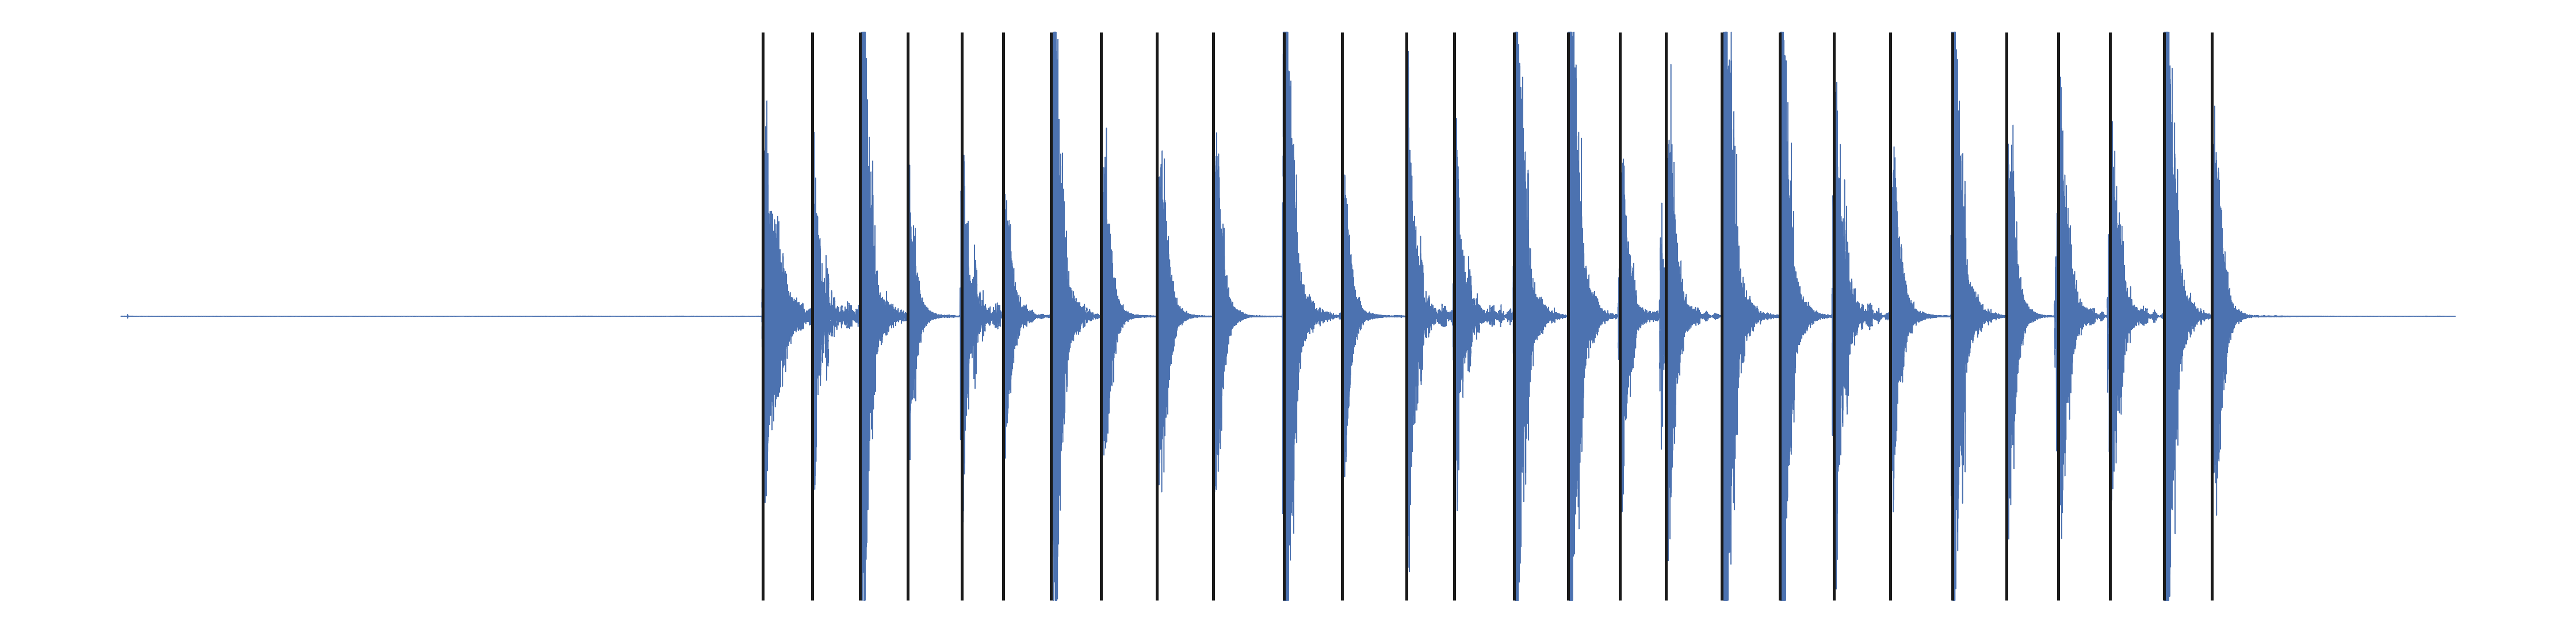

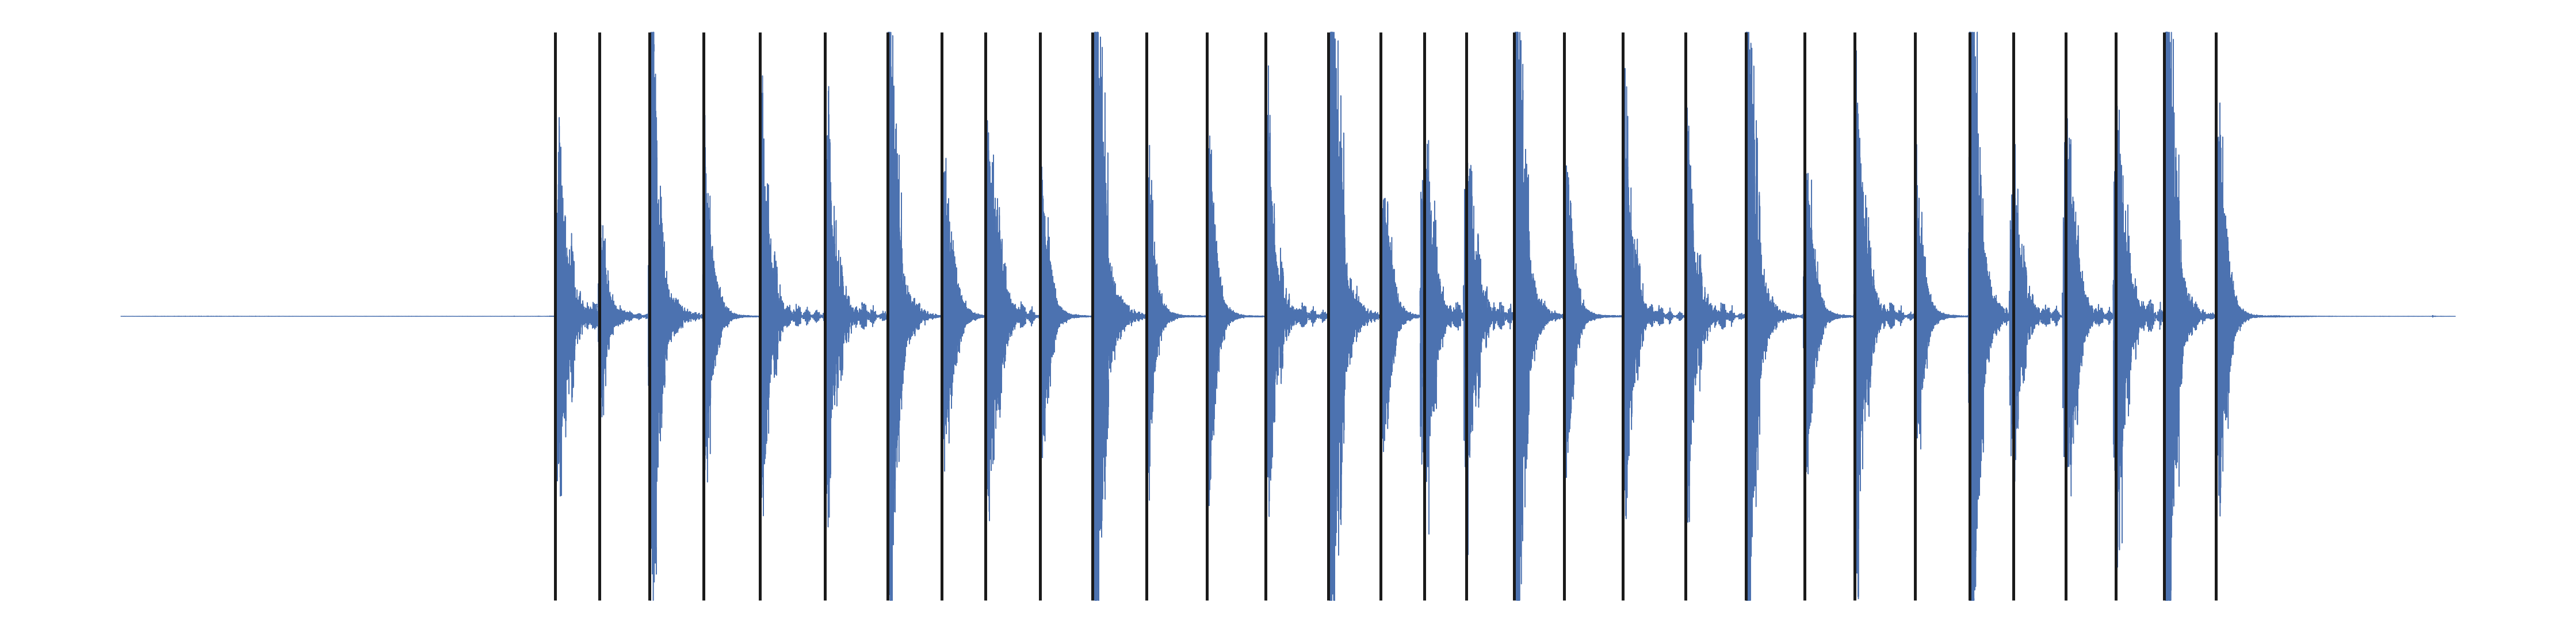

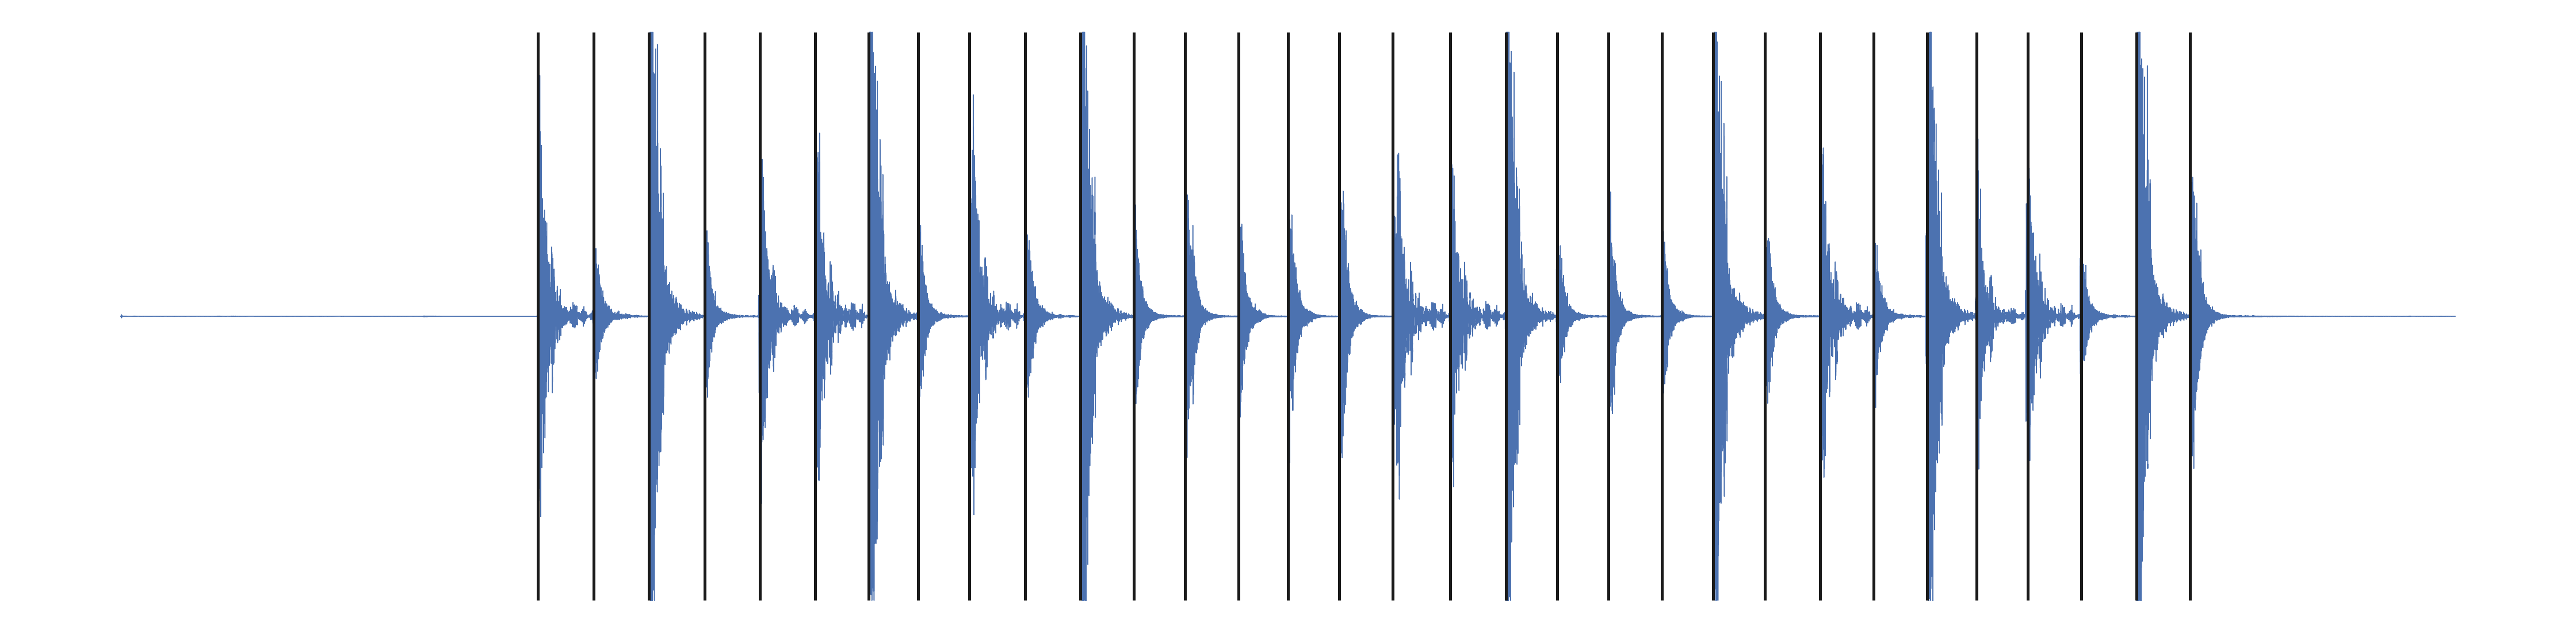

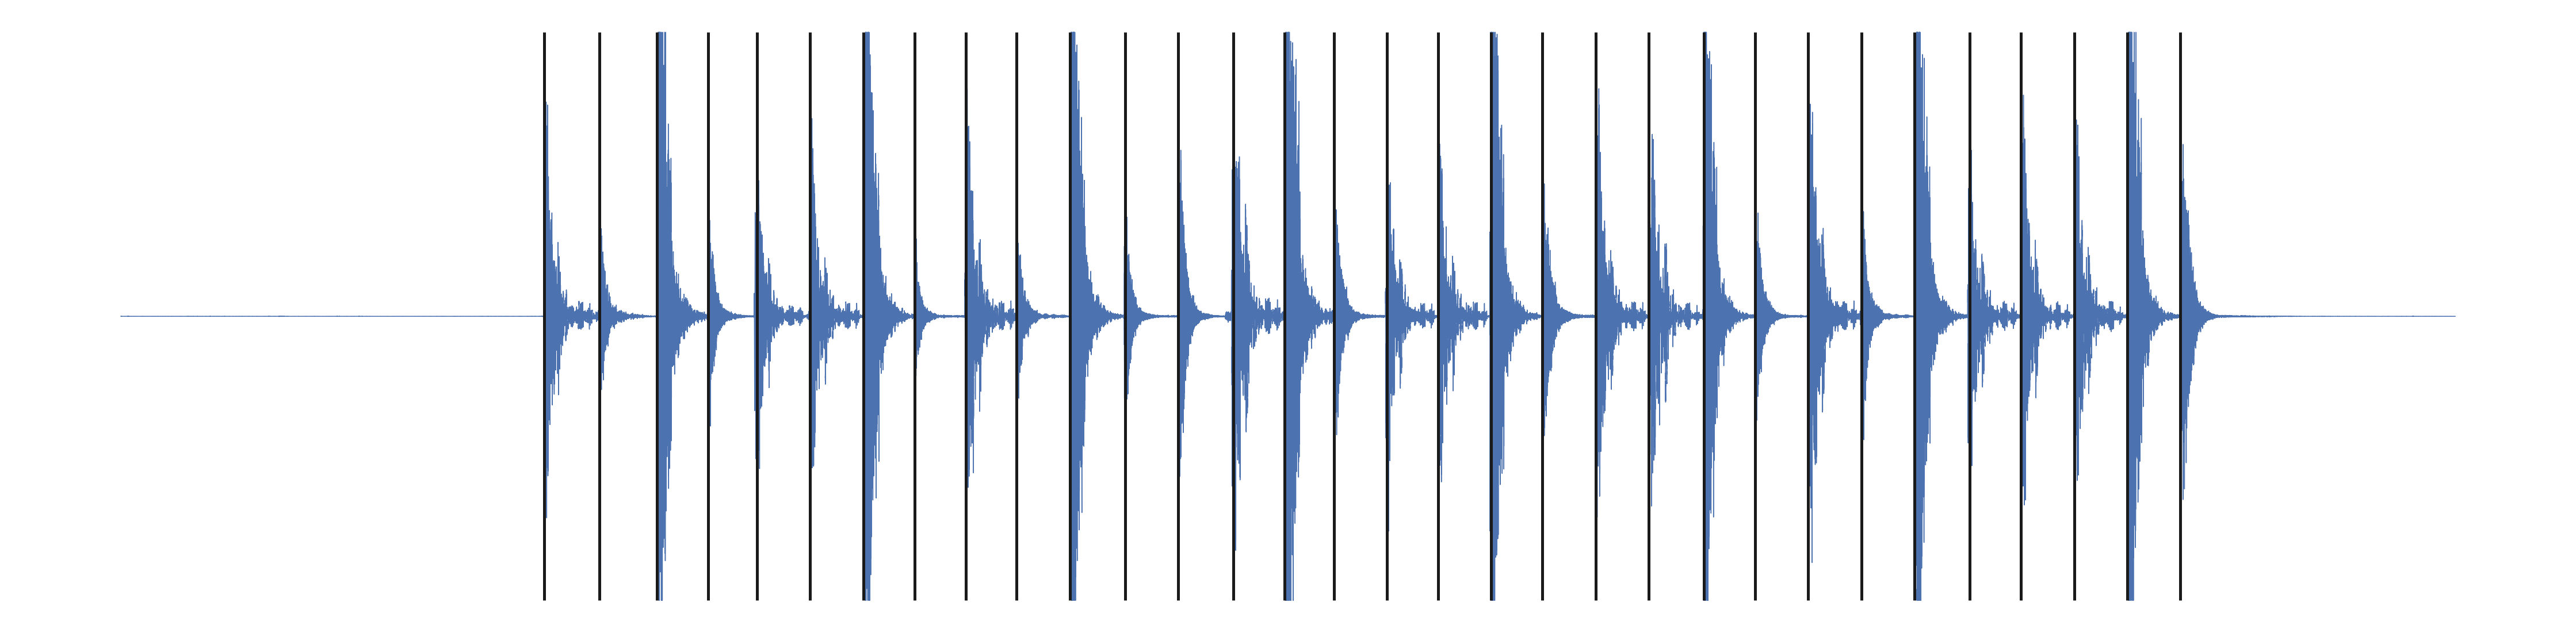

In [20]:
# create dicts to save results and track existing classes
results = dict()
legend = dict()

# get the annotions from the file
annotations = get_Annotations_list_from_file(annotation_file, legend, sr)

# for each submssion
for audio_file in test_exercises:
  # delete slices from previous analysis
  prev_files = get_files_in_dir(submissions + 'slices')
  for f in prev_files:
    os.remove(f)
  # get name and store onsets and featurses
  name = audio_file.split('.')[0]
  results[name] = dict()
  results[name]['audiofile'] = audio_file
  results[name]['onsets'] = SliceDrums_BeatDetection(folder = submissions, audio_filename=audio_file, fs=sr)
  results[name]['features_file'] = '{}_{}.csv'.format(musical_feature_file, name)
  file_count = extract_MusicalFeatures(submissions + 'slices', validation_features, results[name]['features_file'])


In [29]:
# innstance the models class
min_max_scaler = preprocessing.MinMaxScaler()
std_scaler = preprocessing.StandardScaler()

#load the models to pre-process
min_max_scaler = joblib.load(GLOBAL_PATH + '/models/minmax.pck')
std_scaler = joblib.load(GLOBAL_PATH + '/models/std_scaler.pck')

#for each submission
for key in results:
  # load data and preprocess
  data = pd.read_csv(results[key]['features_file'])
  data_modif = data.copy()
  X_ = data_modif.iloc[:].values 
  X_ = min_max_scaler.transform(X_[:,:-1])
  X_ = std_scaler.transform(X_)
  X_test = X_
  results[key]['X_test'] = X_test

In [30]:
# load classifyer
model = joblib.load(GLOBAL_PATH + '/models/SVM.pck')

# for each submission predict the events
for key in results:
  results[key]['y_pred'] = model.predict(results[key]['X_test'])

badTempo_badReading_100_1
	Balanced accuracy:  0.4029720279720279
	Accuracy:  0.4375
	Precision:  0.65625
	F-score:  0.5135416666666667


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1859: UserWarning:

y_pred contains classes not in y_true



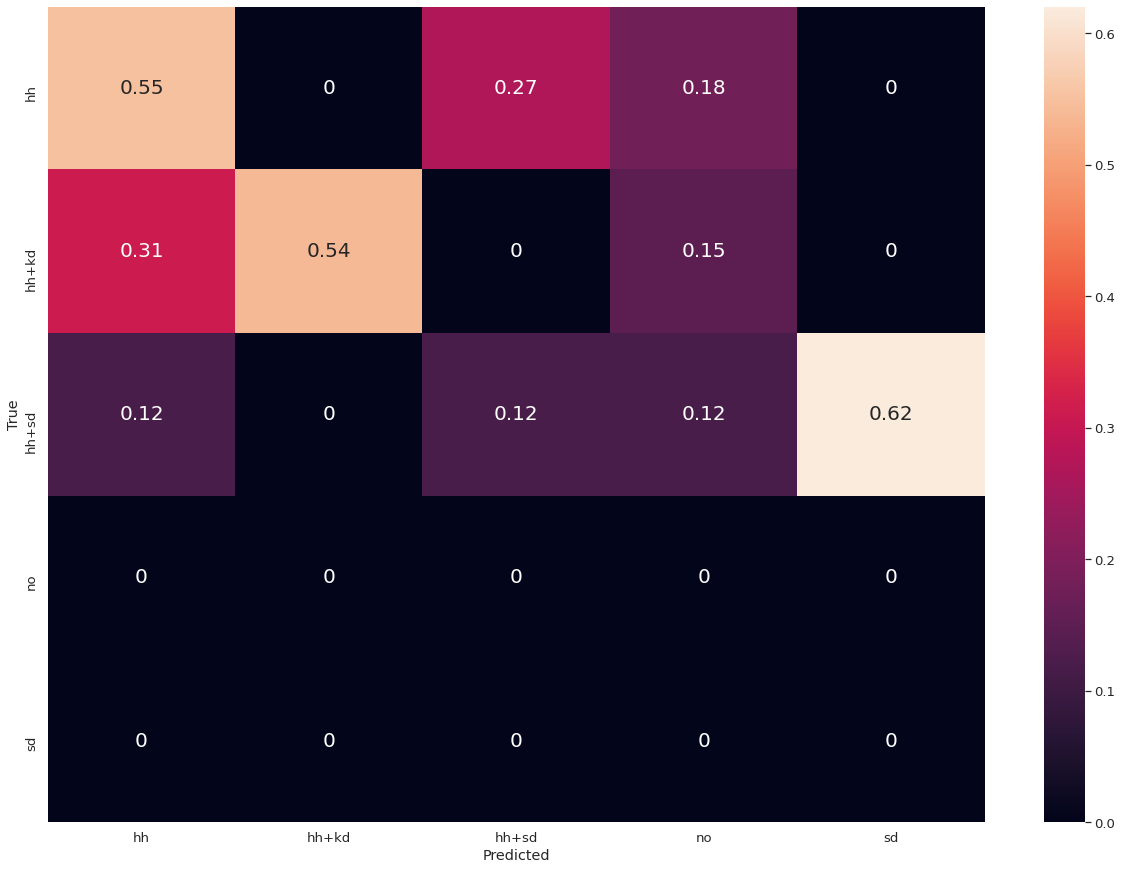

badTempo_goodReading_100_1
	Balanced accuracy:  0.75
	Accuracy:  0.8125
	Precision:  1.0
	F-score:  0.85


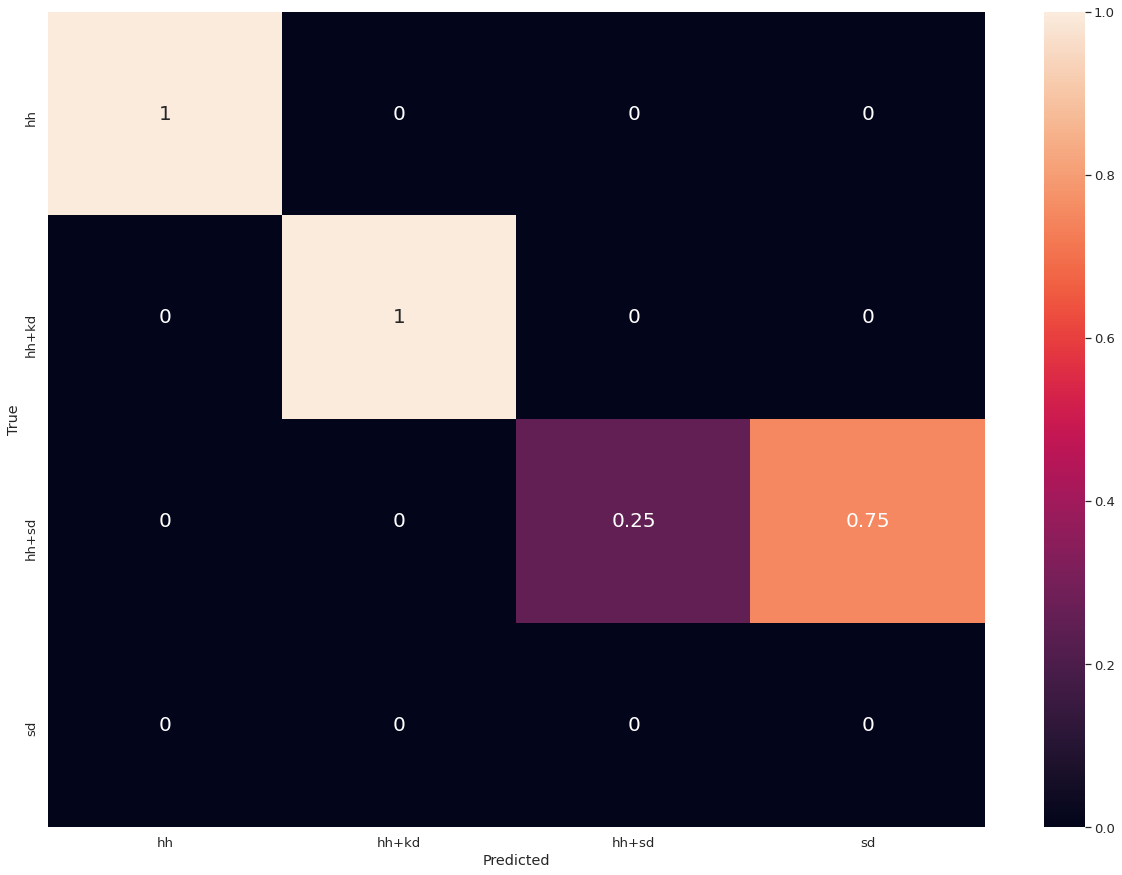

goodTempo_badReading_100_1
	Balanced accuracy:  0.5384615384615384
	Accuracy:  0.59375
	Precision:  0.642578125
	F-score:  0.5896164021164021


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



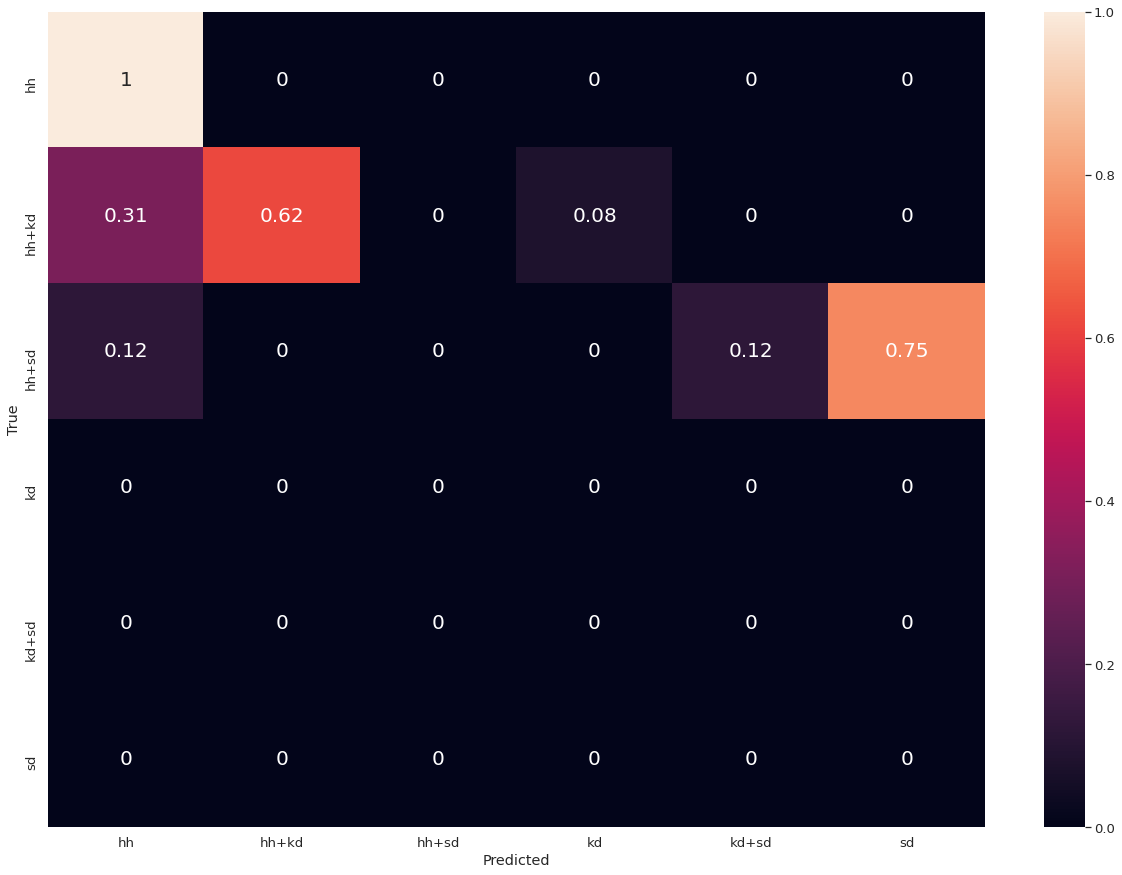

goodTempo_goodReading_100_1
	Balanced accuracy:  0.6666666666666666
	Accuracy:  0.75
	Precision:  0.75
	F-score:  0.75


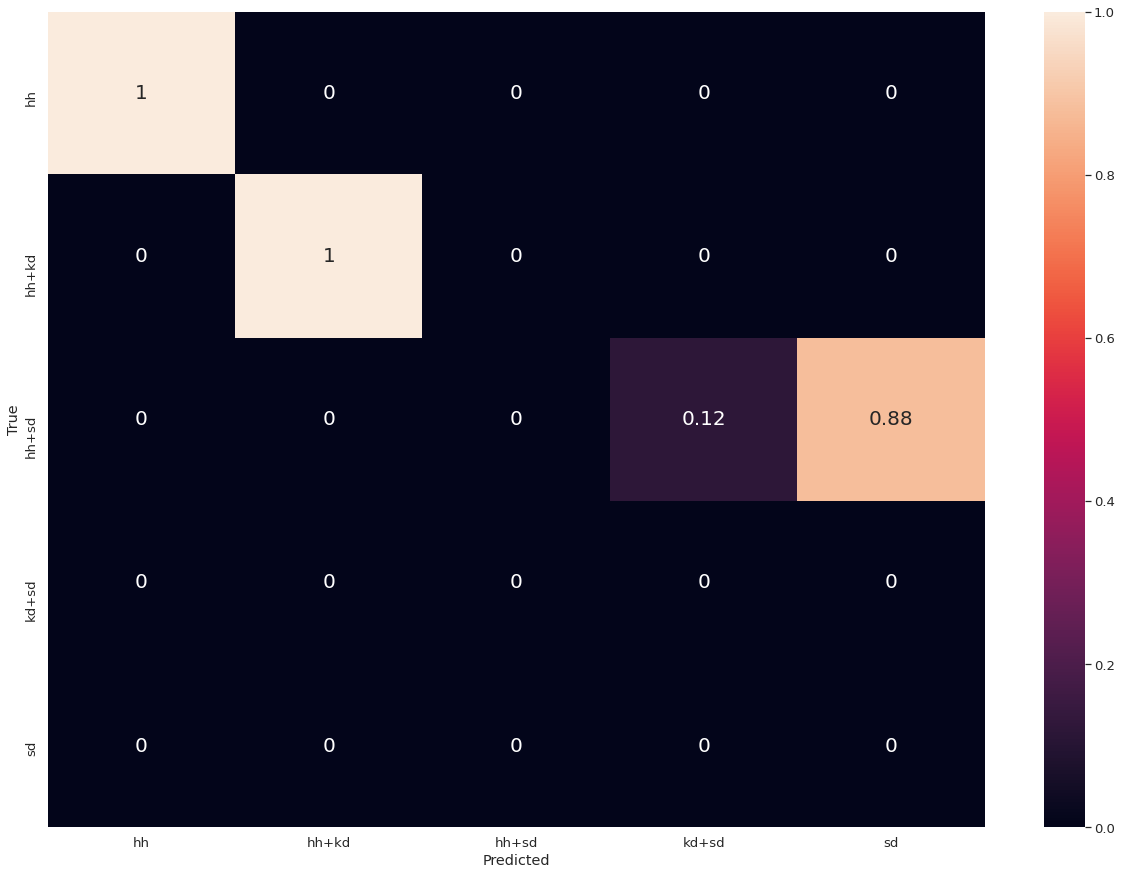

In [31]:
import sklearn.metrics as metric
from sklearn.metrics import confusion_matrix

# get expeted events and onsets
events = [x[1].lower() for x in annotations]
expected_onsets = [x[0] for x in annotations]

# we assume that audio has 4 beats of countback and 1st onset then
left_time = 4*60/bpm
# we assume that audio has 4 bars
right_time = left_time + 60.0/bpm*16

# for each exercise
for key in results:
    # if the number of events is different than the expected we remap the detected event to the nearest expected event
    if len(events) != len(results[key]['y_pred']):
        y_pred_ = map_onsets_with_events(results[key]['onsets'][0] ,np.array(expected_onsets) + left_time, results[key]['y_pred'])
    else: 
        y_pred_ = results[key]['y_pred']

    #store mapped to renderization in next cell and compute indicators  
    results[key]['y_pred_mapped'] = y_pred_
    print(key)
    print('\tBalanced accuracy: ', metric.balanced_accuracy_score(events, y_pred_))
    print('\tAccuracy: ', metric.accuracy_score(events, y_pred_))
    print('\tPrecision: ', metric.precision_score(events, y_pred_, average = 'weighted'))
    print('\tF-score: ', metric.f1_score(events, y_pred_, average = 'weighted'))

    # classes predicted and expected
    classes = np.unique(np.concatenate([np.unique(y_pred_), np.unique(events)]))

    # create a classes dictionary for ploting conf matrix
    values_list = range(len(classes))
    zip_iterator = zip(classes, values_list)
    classes_dictionary = dict(zip_iterator)
    conf_mat = pd.DataFrame(confusion_matrix(events, y_pred_, normalize='true'), columns = classes_dictionary, index = classes_dictionary).round(2)
    conf_mat.index.name = 'True'
    conf_mat.columns.name = 'Predicted'
    plt.figure(figsize = (21,15))
    sns.set(font_scale = 1.2)
    sns.heatmap(conf_mat, annot_kws = {"size": 20}, annot = True);
    plt.show()

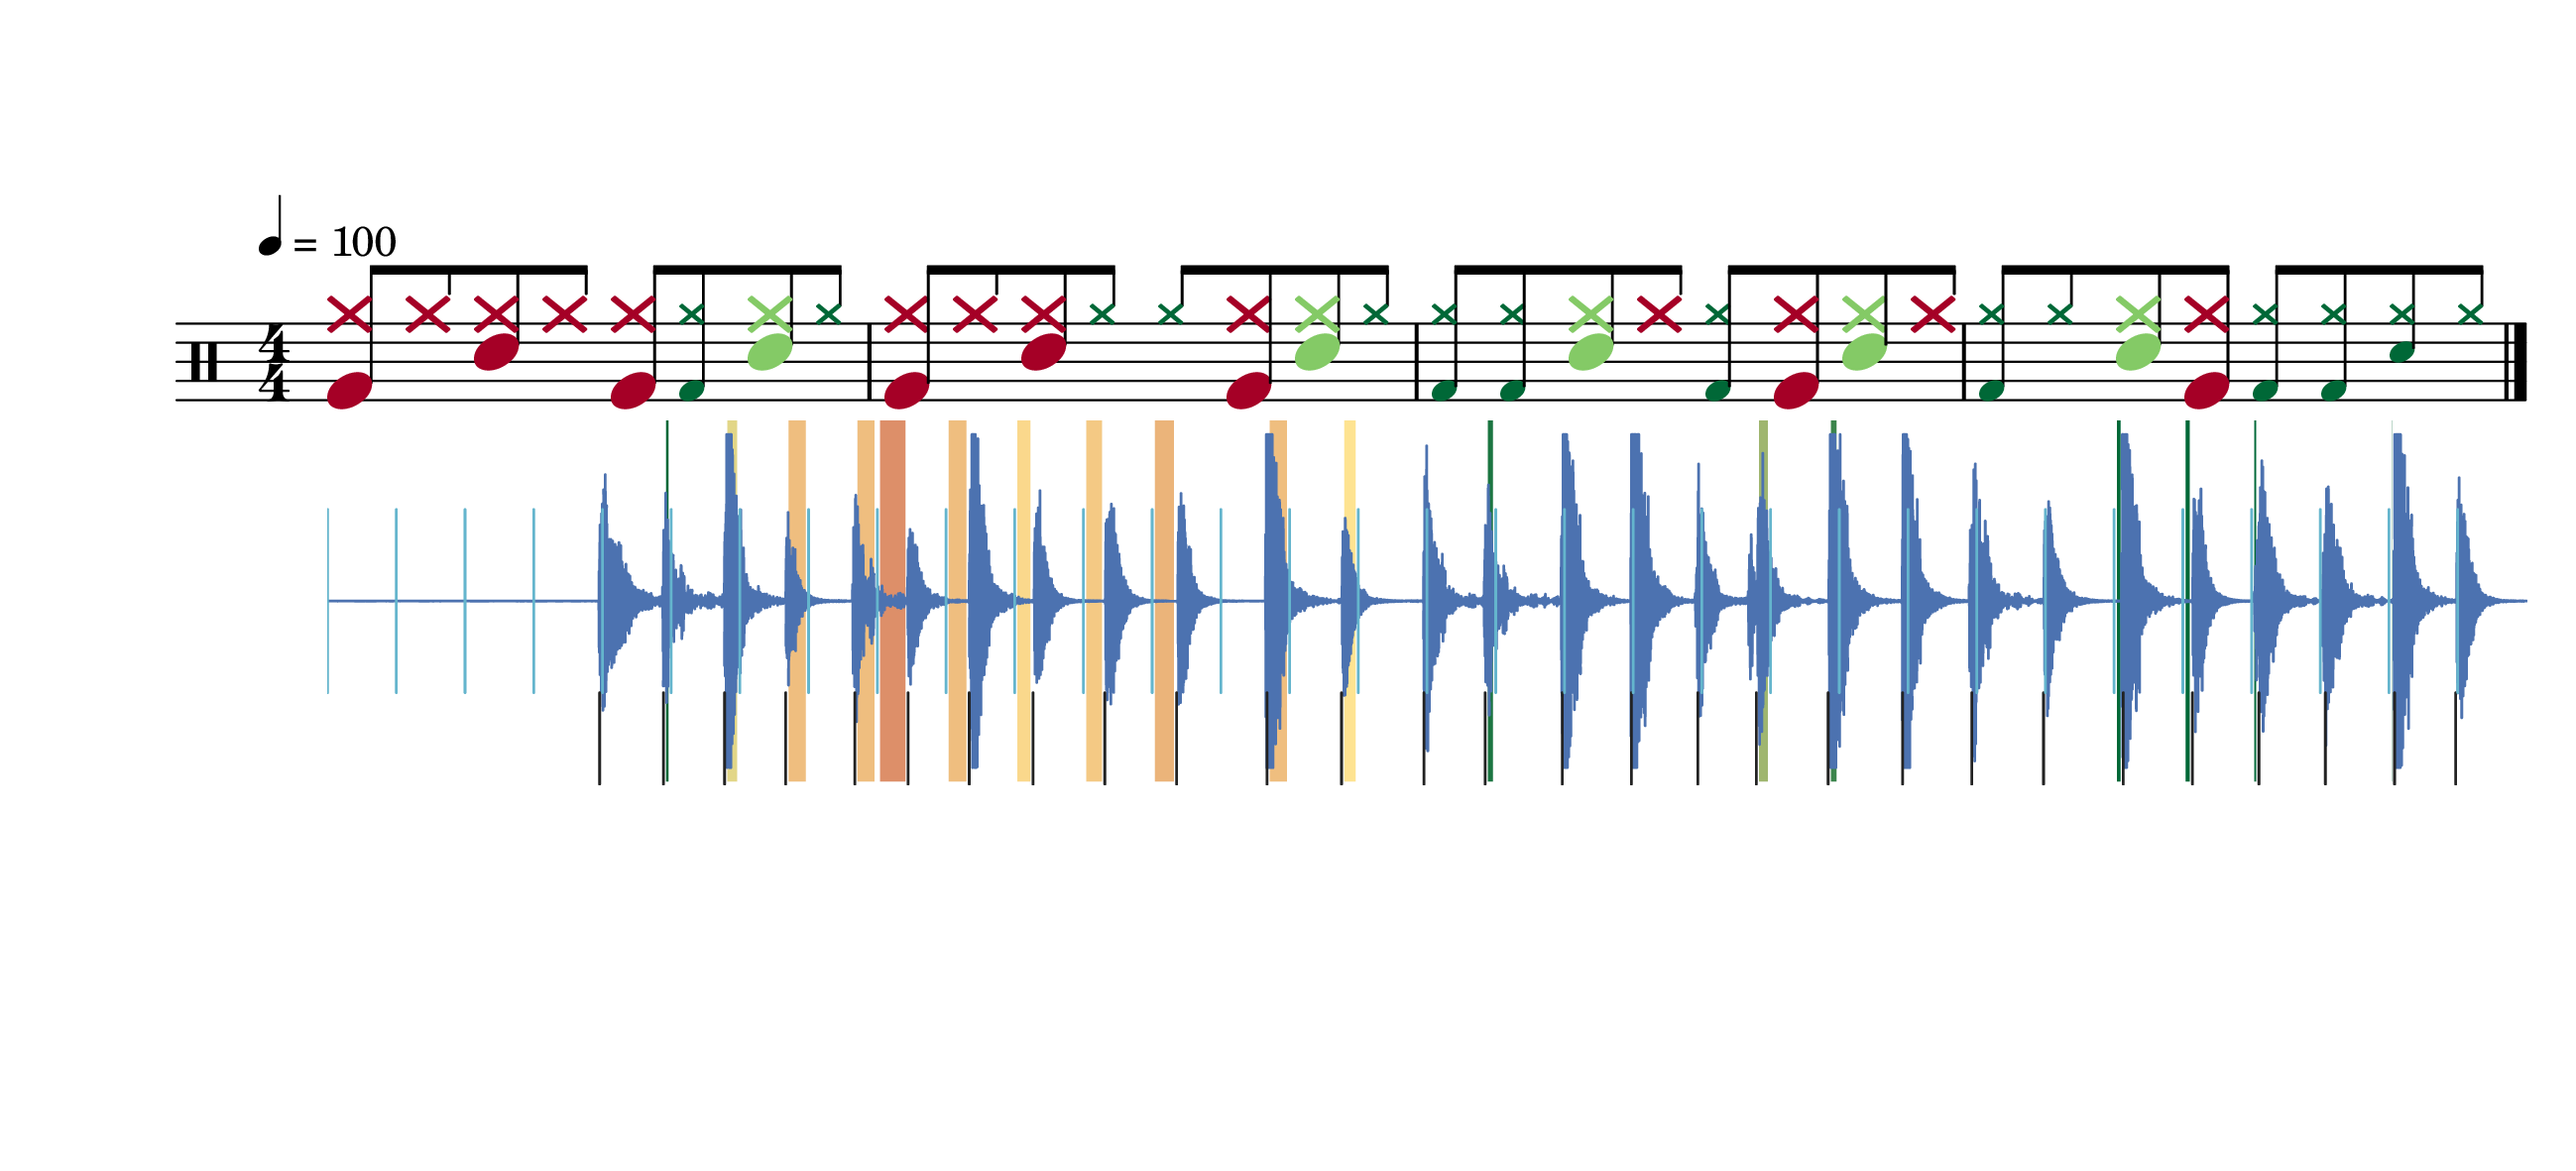

badTempo_badReading_100_1


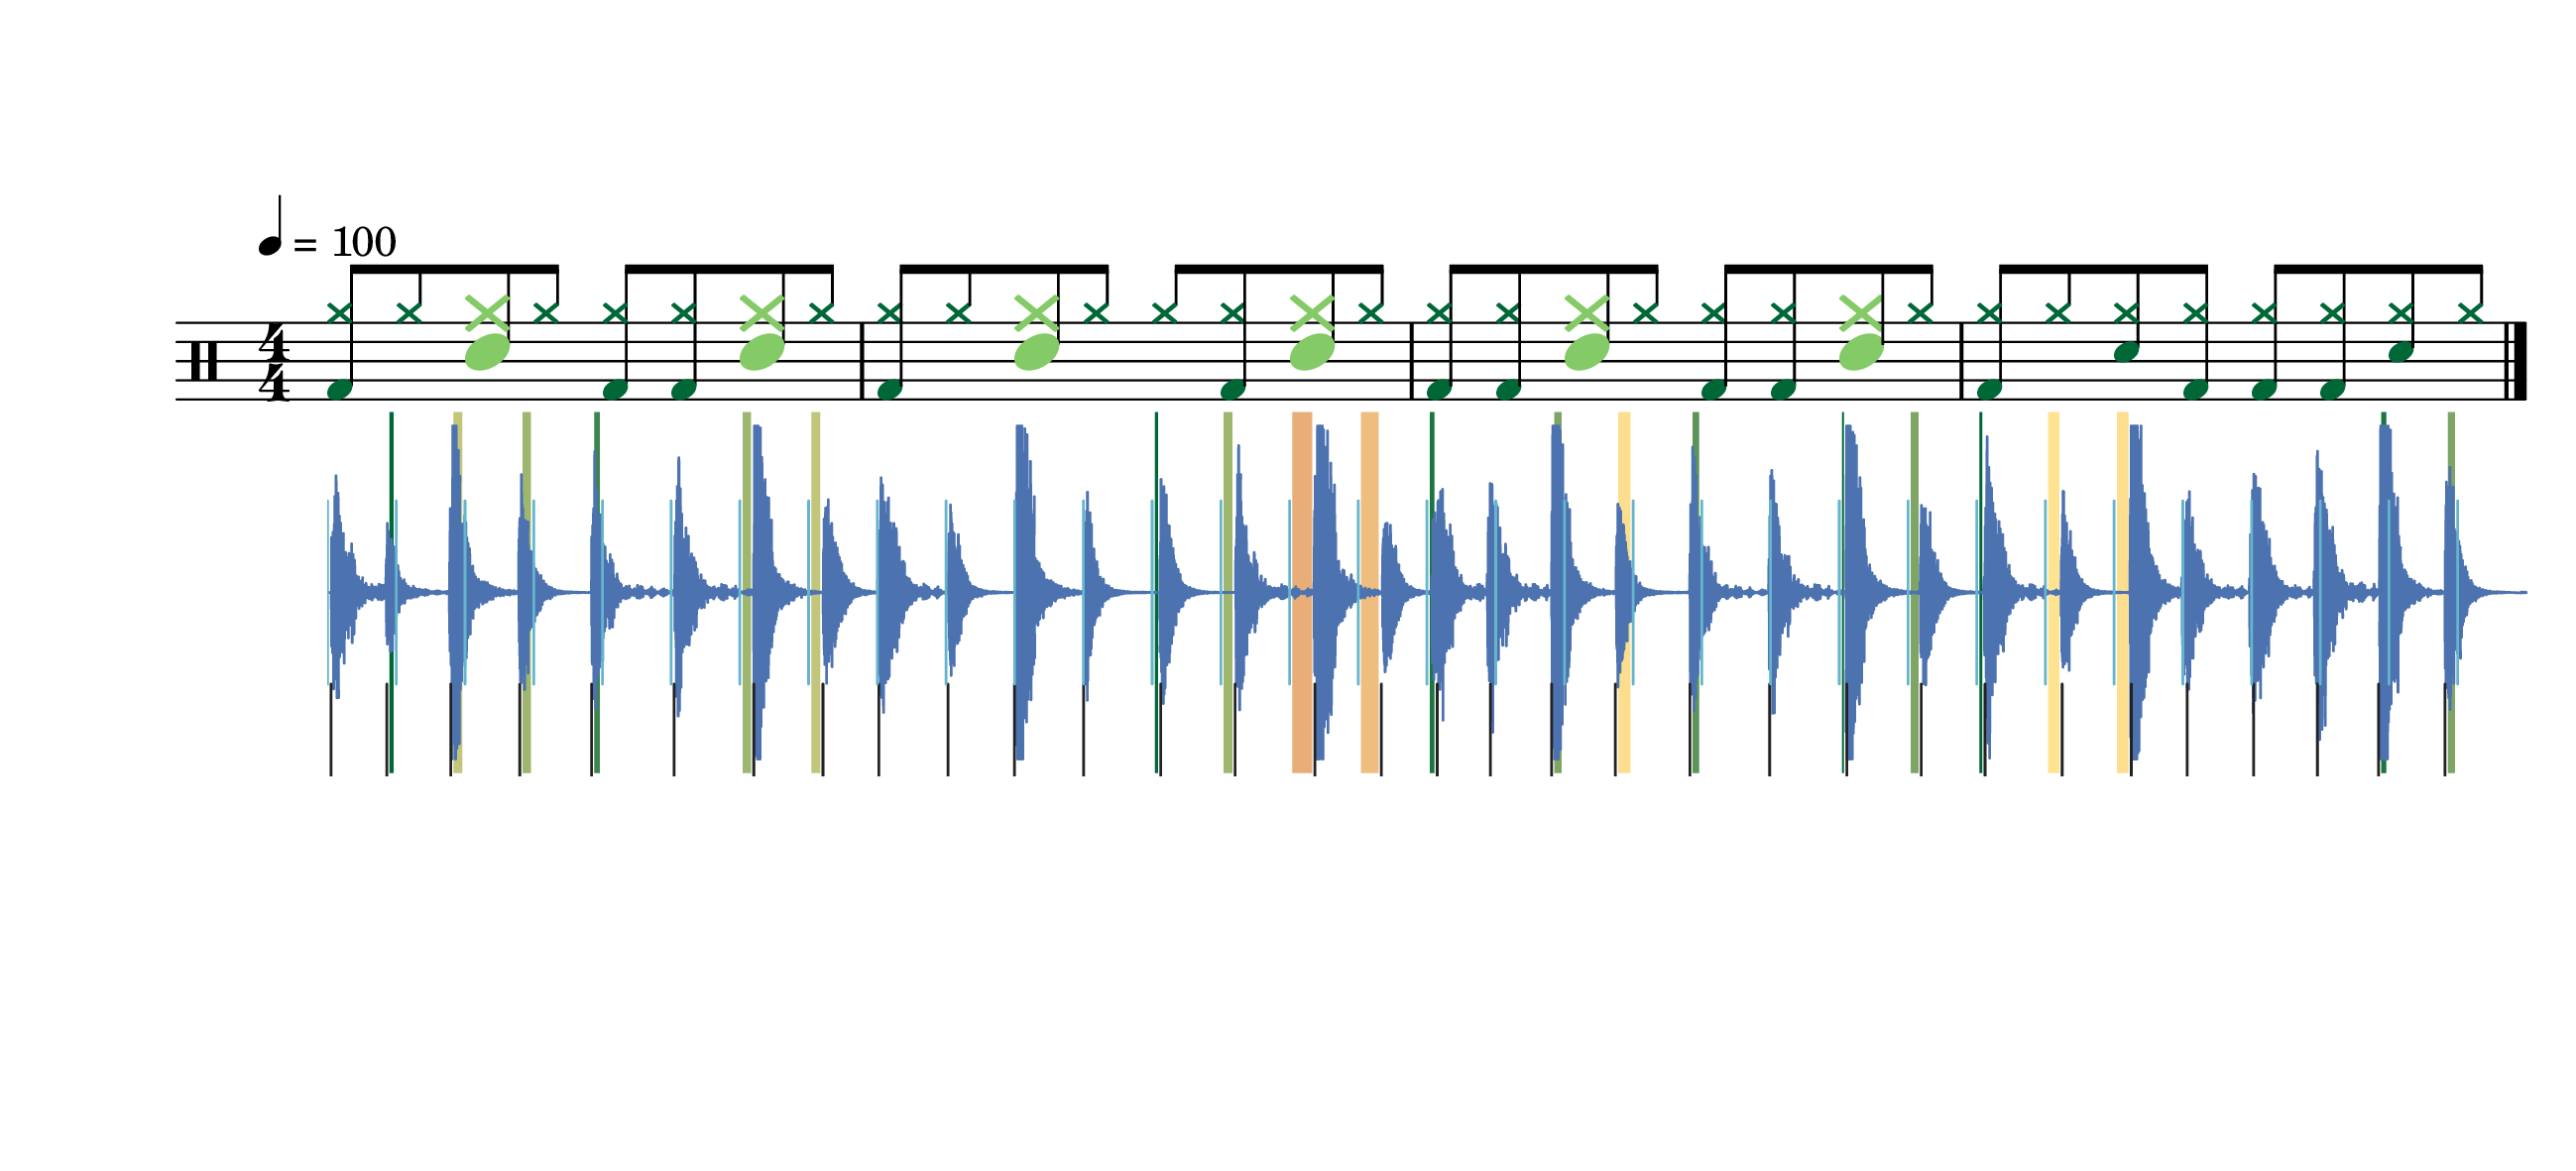

badTempo_goodReading_100_1


/content/drive/MyDrive/TFG/scripts/feature_extraction.py:49: RuntimeWarning:

invalid value encountered in double_scalars

/content/drive/MyDrive/TFG/scripts/feature_extraction.py:50: RuntimeWarning:

invalid value encountered in double_scalars



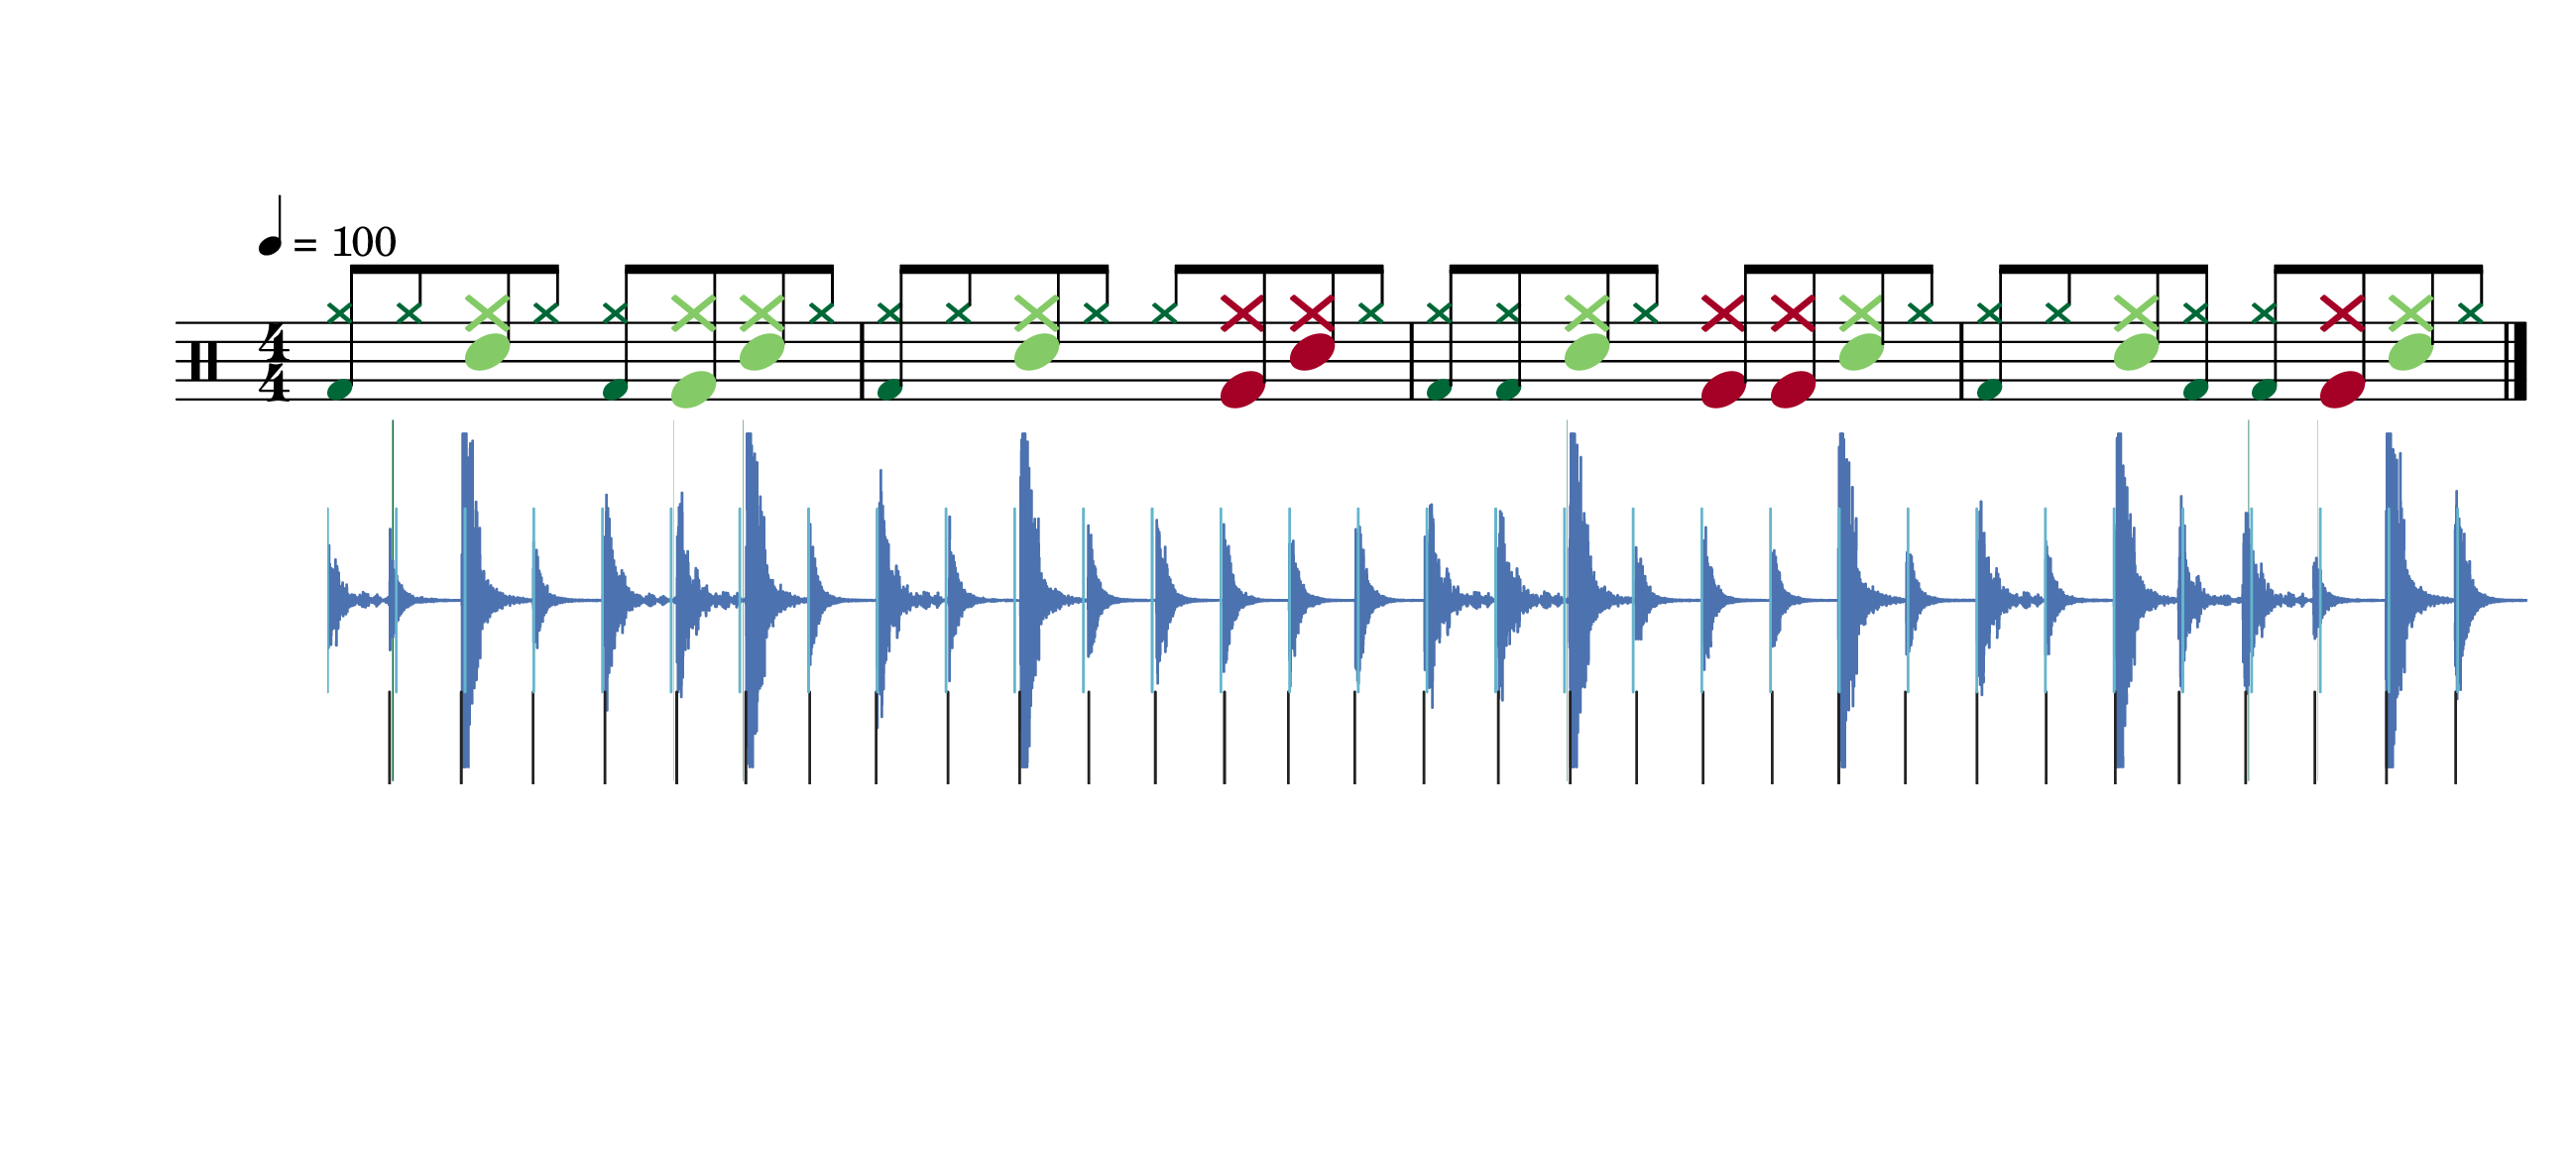

goodTempo_badReading_100_1


/content/drive/MyDrive/TFG/scripts/feature_extraction.py:49: RuntimeWarning:

invalid value encountered in double_scalars

/content/drive/MyDrive/TFG/scripts/feature_extraction.py:50: RuntimeWarning:

invalid value encountered in double_scalars



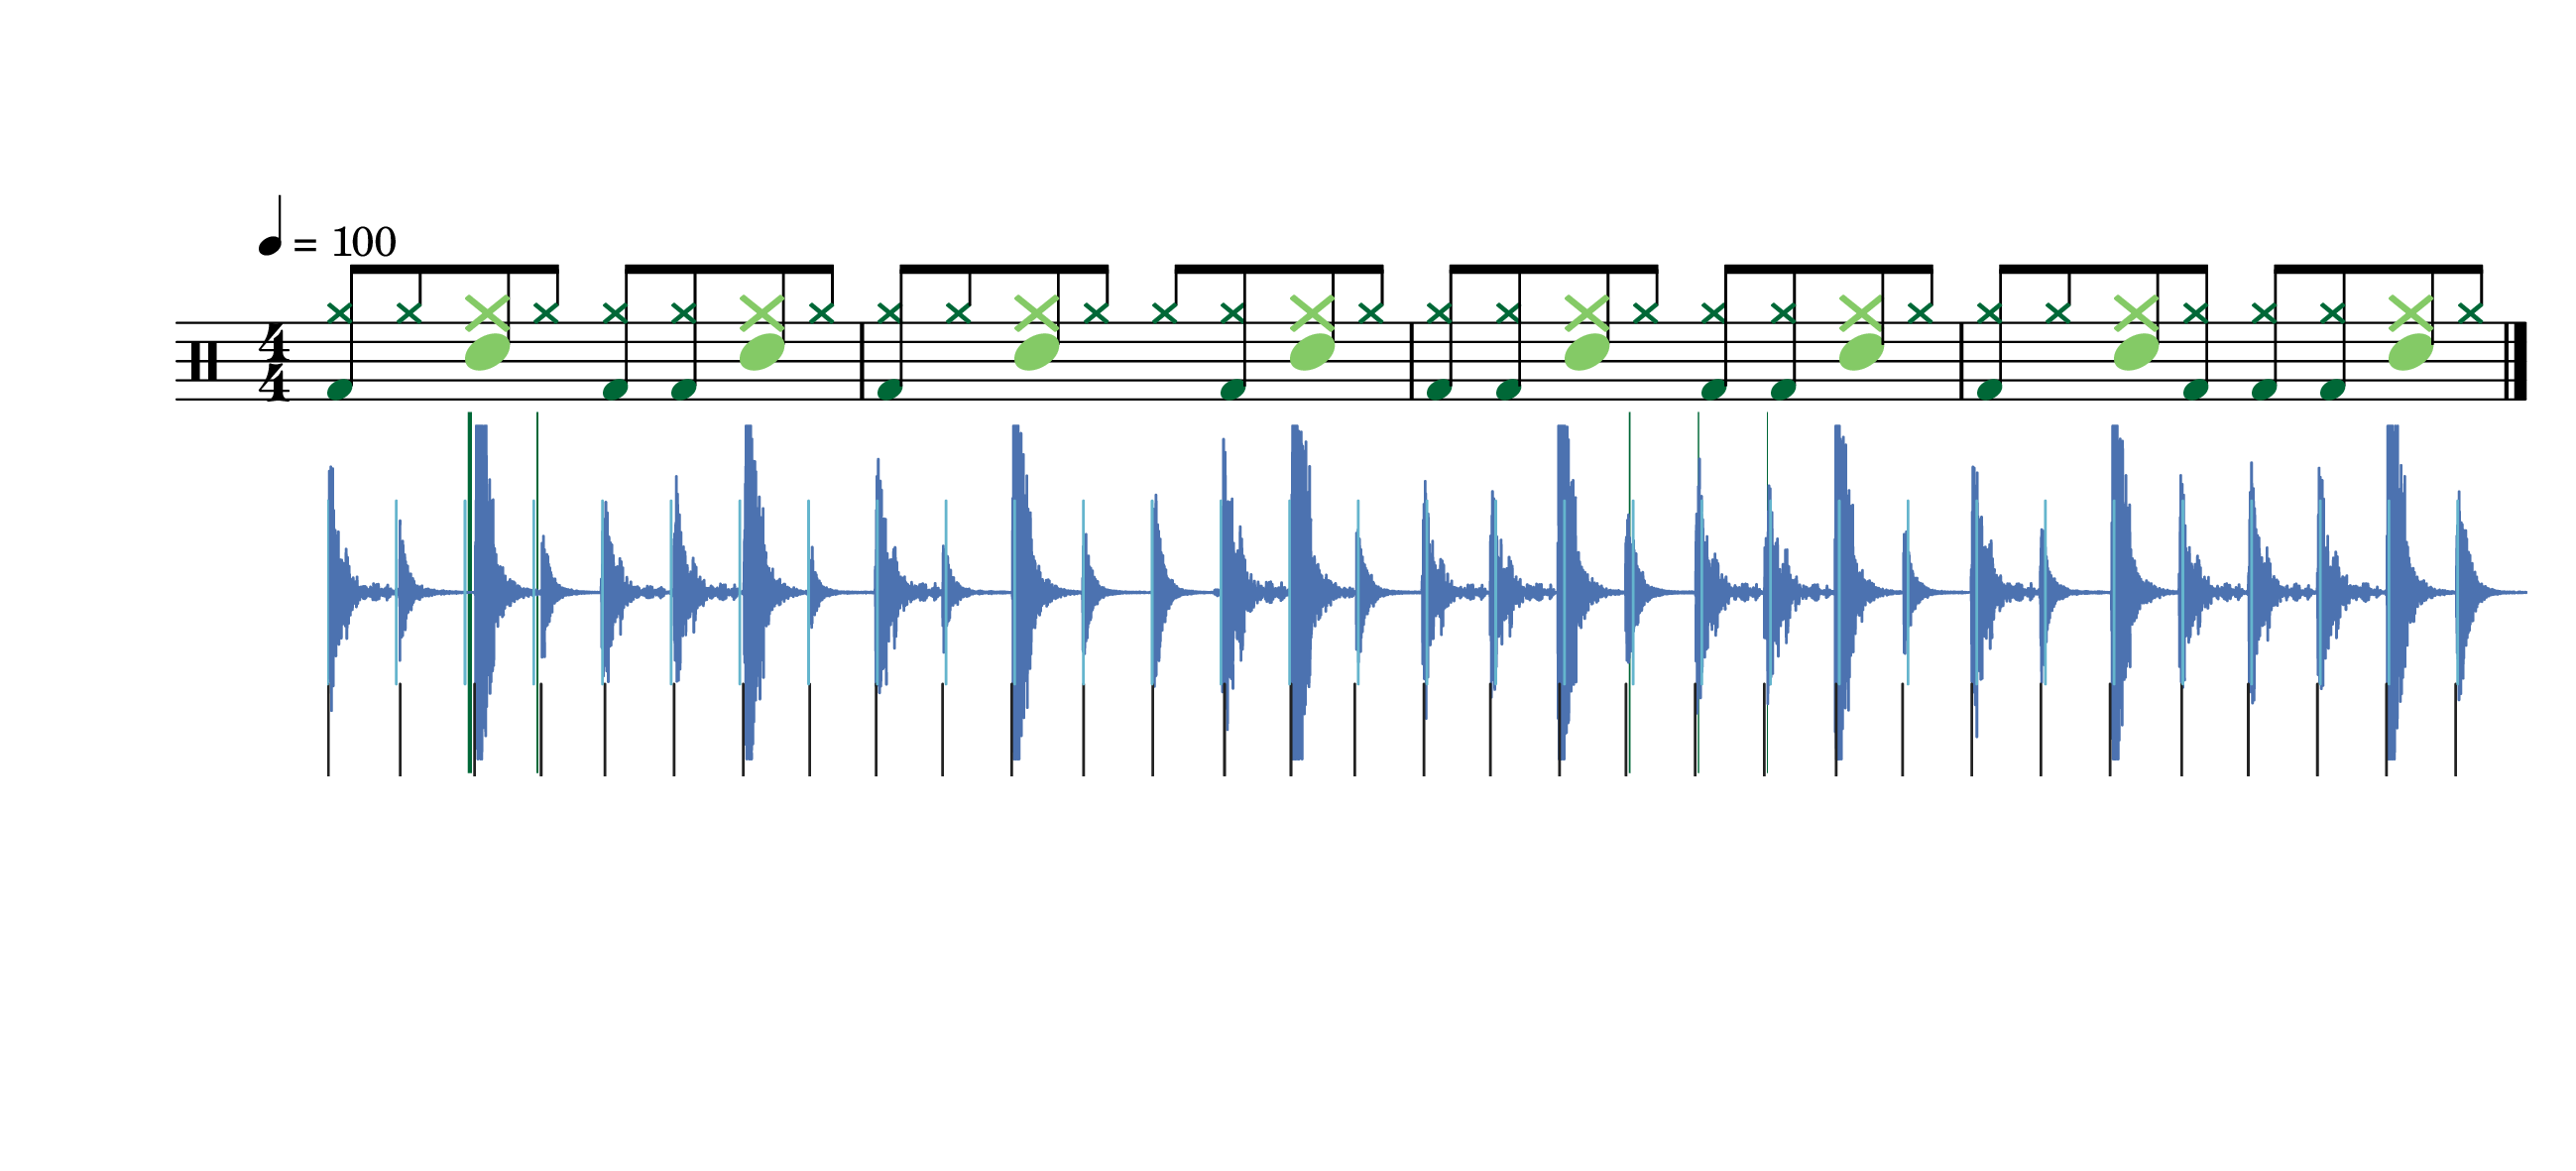

goodTempo_goodReading_100_1


In [32]:
# lilypond paths
lilypond_basedir = os.path.dirname(lilypond)
lilypond_shortname = os.path.basename(lilypond)

# for the different versions on the same exercise
for key in results:
    # load audiofile
    audio = ess.MonoLoader(filename= submissions + results[key]['audiofile'])()
    
    # get onsets detected and events predicted
    onsets = results[key]['onsets'][0]
    y_pred = results[key]['y_pred']


    # compute attacks deviation and timing statistics
    half_ibi = (onsets[1:] - onsets[:-1]).mean() / 2
    start = max(expected_onsets[0] - half_ibi, 0)
    end = expected_onsets[-1] + half_ibi
    devs = attack_deviations(expected_onsets, onsets, start, end)
    results[key]['devs'] = devs
    time_statistics = timing_statistics(devs)
    results[key]['timing_statistics'] = timing_statistics

    # create the iterable waveform to embed in the lilypond render
    eps_lambda = lambda first_bar, last_bar, w, h, left_border_shift, right_border_shift:\
          save_bar_plot(audio, np.array(expected_onsets, dtype=float) ,left_time=left_time + first_bar*60/bpm,right_time=left_time + last_bar*60/bpm,fs=44100, w=6, h=1, dpi=150,
          actual_attacks=np.array(onsets, dtype=float),color_func=attack_rgba) #defining a macro that plot the wave form in lilypond
    
    # assess each event assigning a value from 0 to 1, will be mapped in a colormap from red 0 to green 1
    notes_assessed = assess_notes(events, results[key]['y_pred_mapped'])

    # render the lilypond file with the macros
    file_img_name = score_image(lilypond_basedir,lilypond_shortname,notes_assessed,eps_lambda=eps_lambda,image_format='png') # get the lilypond file with the macros
    
    # display the image rendered
    result_image = Image(filename=file_img_name)
    display(result_image) #display the result in console
    
    # As the image is created in a temporary file it is saved in the Collaboratory machine, folder tmp
    # With this command the image file is moved to my drive folder (avoiding download 1 by 1)
    shutil.move(file_img_name, folder + 'results/' + key + '.png' )
    
    print(key)